In [3]:
from pprint import pprint
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
import keras
from tensorflow.python.framework import ops
#from cnn_utils import *
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import deepdish.io as io
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
#from keras.utils import multi_gpu_model
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [4]:
#Loading data
data_sig_A = io.load(os.path.join('MEM-A-0500_unscaled_signal.h5'))
data_sig_B = io.load(os.path.join('MEM-B-0500_unscaled_signal.h5'))
data_sig_C = io.load(os.path.join('MEM-C-0500_unscaled_signal.h5'))
data_back_A = io.load(os.path.join('MEM-A-0500_unscaled_background.h5'))
data_back_B = io.load(os.path.join('MEM-B-0500_unscaled_background.h5'))
data_back_B.keys()

['y', 'X', 'bkg_llh']

In [3]:
#Assigning data
X_Big_train = data_sig_A['X']
target_BigSig_train = data_sig_A['signal_llh']
y_BigSig_train = data_sig_A['y']

X_Big_test = data_sig_B['X']
target_BigSig_test = data_sig_B['signal_llh']
y_BigSig_test = data_sig_B['y']

X_Big_valid = data_sig_C['X']
target_BigSig_valid = data_sig_C['signal_llh']
y_BigSig_valid = data_sig_C['y']

target_BigBack_train = data_back_A['bkg_llh']
y_BigBack_train = data_back_A['y']
target_BigBack_test = data_back_B['bkg_llh']
y_BigBack_test = data_back_B['y']

sig_to_backRatio_train = target_BigSig_train/target_BigBack_train
sig_to_backRatio_test = target_BigSig_test/target_BigBack_test

np.shape(y_BigSig_valid)
#print np.shape(target_BigSig_test)
#print np.shape(target_BigBack_test)
print np.shape(sig_to_backRatio_train)
print np.shape(sig_to_backRatio_test)

(3028985,)
(151449,)


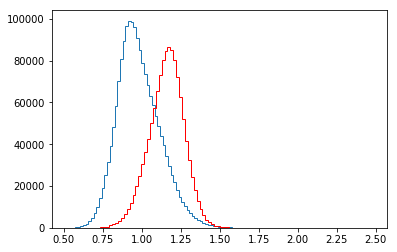

In [20]:
#_=plt.hist(target_BigSig_test[np.where(y_BigSig_test==1)],bins=100, histtype='step', label=' signal llh')
                           
#_=plt.hist(target_BigSig_test[np.where(y_BigSig_test==0)],bins=100, histtype='step', color= 'red')

_=plt.hist(sig_to_backRatio_train[np.where(y_BigSig_train==1)],bins=100, histtype='step')
                           
_=plt.hist(sig_to_backRatio_train[np.where(y_BigSig_train==0)],bins=100, histtype='step', color= 'red')

#_=plt.hist(sig_to_backRatio_train,bins=100, histtype='step')

#plt.legend(['training', 'validation'], loc='upper right')
#_=plt.hist(target_BigSig_test,bins=100)
#_=plt.hist(target_BigBack_test,bins=100)

In [17]:
#Defining Sequential Model
def sequential_model():
    seqModel = Sequential()
    seqModel.add(Dense(32, input_dim=32, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(12, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(1, kernel_initializer='glorot_normal'))
    seqModel.compile(loss='mean_squared_error', optimizer='adam')
    return seqModel

In [18]:
#calling sequential model using standard scaler
estimators = []
estimators.append(('standardize', StandardScaler()))

estimators.append(('mlp', KerasRegressor(build_fn=sequential_model, epochs=100, batch_size=256, verbose=1)))
pipeline1 = Pipeline(estimators)
train=pipeline1.fit(X_Big_train,sig_to_backRatio_train)
seqResult = pipeline1.predict(X_Big_test)
print("Standardized: %.2f (%.2f) MSE" % (seqResult.mean(), seqResult.std()))
print np.shape(seqResult), np.max(seqResult), np.min(seqResult)

Epoch 1/100
3028985/3028985 [==============================] - 18s 6us/step - loss: 0.0194
Epoch 2/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0130
Epoch 3/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0126
Epoch 4/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0123
Epoch 5/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0121
Epoch 6/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0120
Epoch 7/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0119
Epoch 8/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0118
Epoch 9/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0117
Epoch 10/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0116
Epoch 11/100
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.01

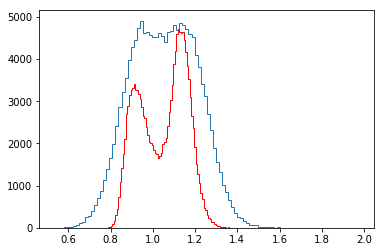

In [19]:
_=plt.hist(sig_to_backRatio_test,bins=100, histtype='step')
_=plt.hist(seqResult,bins=100, color= 'red', histtype='step')

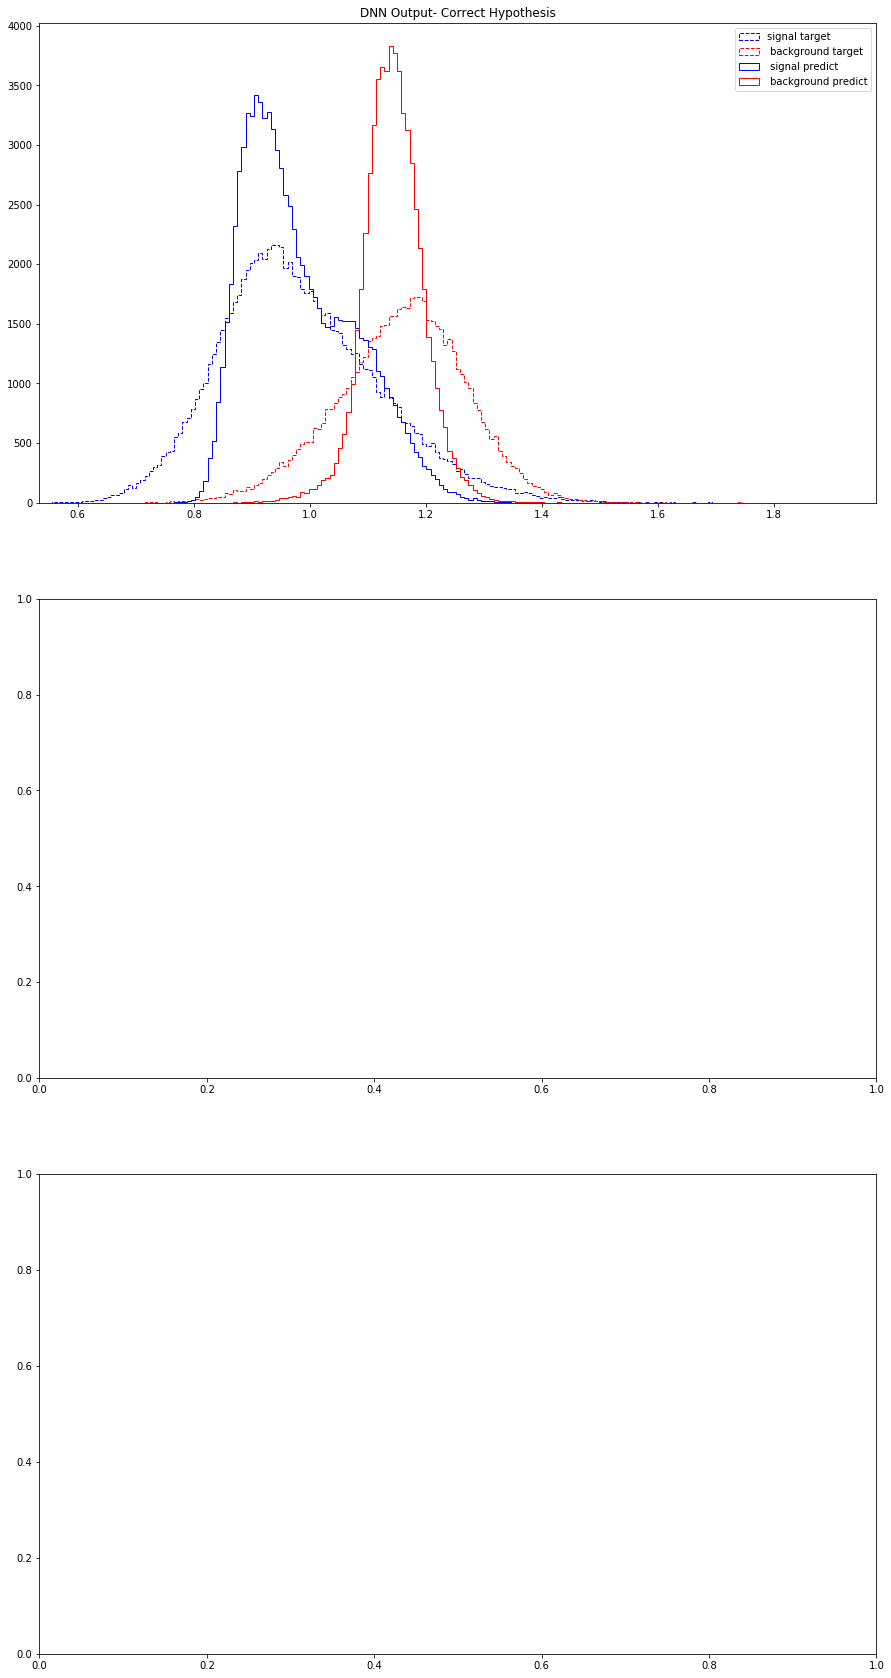

In [30]:
sti=sig_true_i=np.where(y_BigSig_test==1)[0]
bti=bkg_true_i=np.where(y_BigSig_test==0)[0]

n_datasets = 1
n_plots = 3
n_bins = 200
f1, axarr1 = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(15, 30),
                            squeeze=False)
plot_i1=0
plot_title="DNN Output- Correct Hypothesis"

min_out1=min(sig_to_backRatio_test.min(),seqResult.min())
max_out1=max(sig_to_backRatio_test.max(),seqResult.max())
bins_out1 = np.linspace(min_out1,max_out1,n_bins)
axarr1[plot_i1,0].set_xlim((min_out1,max_out1))
        
axarr1[plot_i1,0].hist(sig_to_backRatio_test[sti], color='blue', histtype='step', bins=bins_out1, linestyle='dashed', label='signal target')

axarr1[plot_i1,0].hist(sig_to_backRatio_test[bti], color='red', histtype='step', bins=bins_out1, linestyle='dashed', label=' background target')
axarr1[plot_i1,0].hist(seqResult[sti], color='blue', histtype='step', bins=bins_out1, linestyle='solid', label=' signal predict') 
axarr1[plot_i1,0].hist(seqResult[bti], color='red', histtype='step', bins=bins_out1, linestyle='solid', label=' background predict')
        
axarr1[plot_i1][0].set_title(plot_title)
axarr1[plot_i1][0].legend(loc='best', ncol=1)



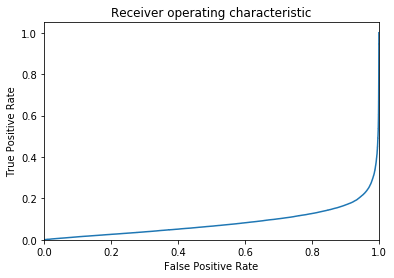

In [66]:
fpr, tpr, thresholds = roc_curve(y_BigSig_test,seqResult)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [63]:
y_BigSig_test

array([1, 1, 1, ..., 1, 1, 1])

In [64]:
seqResult

array([0.96143323, 1.0590225 , 0.8678651 , ..., 0.9105636 , 0.93391466,
       0.9763154 ], dtype=float32)